In [1]:
import io
import requests
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

The data being used is from 538's [How Popular is Donald Trump](https://projects.fivethirtyeight.com/trump-approval-ratings/), it grabs the most recent version of their poll numbers

In [2]:
url = "https://projects.fivethirtyeight.com/trump-approval-data/approval_polllist.csv"
df = pd.read_csv(url, parse_dates = ['createddate'])

The features I'm using are createddate, adjusted_approve, and adjusted_disapprove.

In [3]:
df.head(3)

,president,subgroup,modeldate,startdate,enddate,pollster,grade,samplesize,population,weight,...,disapprove,adjusted_approve,adjusted_disapprove,multiversions,tracking,url,poll_id,question_id,createddate,timestamp
0,Donald Trump,All polls,12/24/2019,1/20/2017,1/22/2017,Morning Consult,B/C,1992.0,rv,0.696984,...,37.0,44.403236,38.565439,NaN,NaN,http://static.politico.com/9b/13/82a3baf542ae9...,49249,77261,2017-01-23,09:47:07 24 Dec 2019
1,Donald Trump,All polls,12/24/2019,1/20/2017,1/22/2017,Gallup,B,1500.0,a,0.241682,...,45.0,45.825535,43.485445,NaN,T,http://www.gallup.com/poll/201617/gallup-daily...,49253,77265,2017-01-23,09:47:07 24 Dec 2019
2,Donald Trump,All polls,12/24/2019,1/20/2017,1/24/2017,Ipsos,B-,1632.0,a,0.150785,...,45.2,42.713242,44.115669,NaN,T,http://polling.reuters.com/#poll/CP3_2/,49426,77599,2017-03-01,09:47:07 24 Dec 2019


A little messy, but we're building a new dataframe that lists if a rating is approval or disapproval along with the rating. Also, the disapproval numbers are negative.

In [4]:
df_approve = df[['createddate', 'adjusted_approve']]
df_disapprove = df[['createddate', 'adjusted_disapprove']]

df_approve['Category'] = 'approve'
df_disapprove['Category'] = 'disapprove'

df_merged = pd.concat([df_approve, df_disapprove], axis = 0)
df_merged['adjusted_disapprove'] = df_merged['adjusted_disapprove'] * -1
df_merged['rating'] = df_merged.fillna(0)['adjusted_approve'] + df_merged.fillna(0)['adjusted_disapprove']
df_merged = df_merged[['Category', 'createddate', 'rating']]

In [5]:
df_merged

,Category,createddate,rating
0,approve,2017-01-23,44.403236
1,approve,2017-01-23,45.825535
2,approve,2017-03-01,42.713242
3,approve,2017-01-24,45.825535
4,approve,2017-01-26,37.601182
...,...,...,...
10603,disapprove,2019-12-20,-56.377362
10604,disapprove,2019-12-23,-51.752946
10605,disapprove,2019-12-24,-51.752946
10606,disapprove,2019-12-23,-54.692543


In [27]:
approval = df_merged[df_merged['Category'] == 'approve']

approval.head(3)

,Category,createddate,rating
0,approve,2017-01-23,44.403236
1,approve,2017-01-23,45.825535
2,approve,2017-03-01,42.713242


In [ ]:
# cols = ['president', 'subgroup', 'modeldate', 'startdate', 'enddate', 'pollster', 'grade', 'samplesize', 'population', 'weight', 'influence', 'approve', 'disapprove', 'multiversions', 'tracking', 'url', 'poll_id', 'question_id', 'timestamp']
# df.drop(cols, axis=1, inplace=True)
# df_polls = df.sort_values('createddate')
# df_polls.isnull().sum()

In [28]:
approval = approval.groupby('createddate')
approval = approval['rating'].mean().reset_index()
approval = approval.set_index('createddate')
approval.head(3)

,rating
createddate,
2017-01-23,45.090033
2017-01-24,45.406605
2017-01-25,47.363760


Weekly approval ratings based on the mean.

In [29]:
y = approval['rating'].resample('W').mean()

In [32]:
y

createddate
2017-01-29    45.363425
2017-02-05    44.862583
2017-02-12    44.010631
2017-02-19    43.373042
2017-02-26    42.925464
                ...    
2019-12-01    41.034733
2019-12-08    41.728068
2019-12-15    42.492557
2019-12-22    42.478181
2019-12-29    42.361384
Freq: W-SUN, Name: rating, Length: 153, dtype: float64

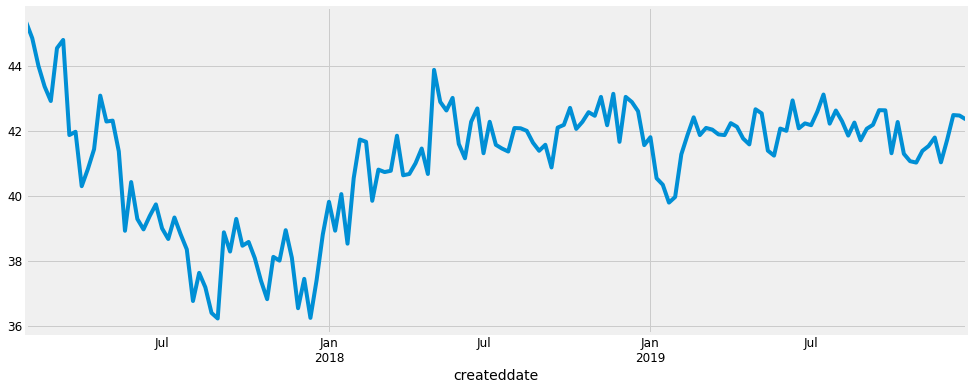

In [33]:
y.plot(figsize=(15, 6))
plt.show()

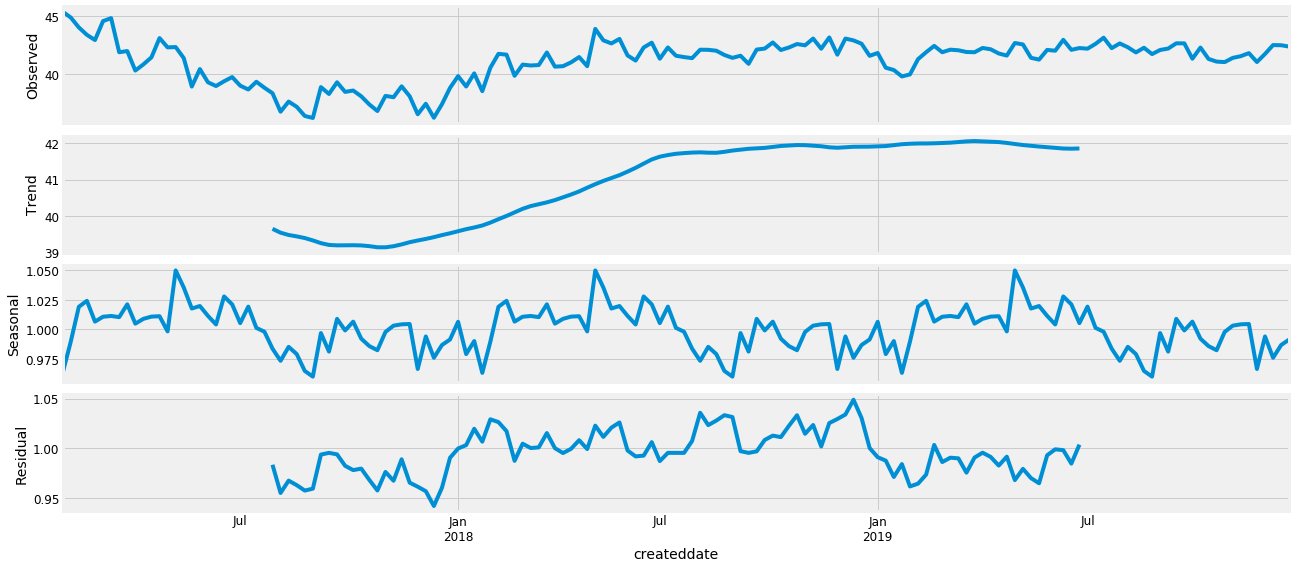

In [39]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative', freq = 52)
fig = decomposition.plot()
plt.show()

# Using the Dickey-Fuller test to test stationarity

> In the most intuitive sense, stationarity means that the statistical properties of a process generating a time series do not change over time.

**Source:** [Stationarity in time series analysis](https://towardsdatascience.com/stationarity-in-time-series-analysis-90c94f27322), Shay Palachy

Function adapted from [Seasonal ARIMA with Python](https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/) by Sean Abu:

In [139]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(52).mean()
    rolstd = timeseries.rolling(52).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

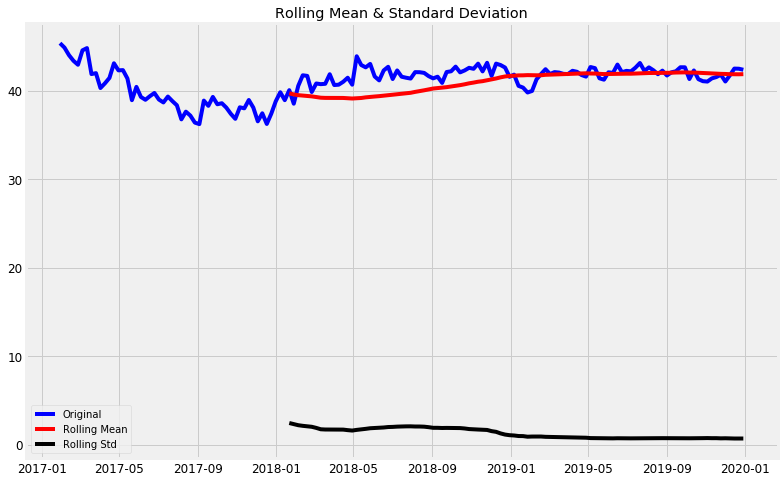

Results of Dickey-Fuller Test:
Test Statistic                  -1.963635
p-value                          0.302742
#Lags Used                      13.000000
Number of Observations Used    139.000000
Critical Value (1%)             -3.478294
Critical Value (5%)             -2.882568
Critical Value (10%)            -2.577983
dtype: float64


In [140]:
test_stationarity(y)

In [285]:
y_df = pd.DataFrame(y)

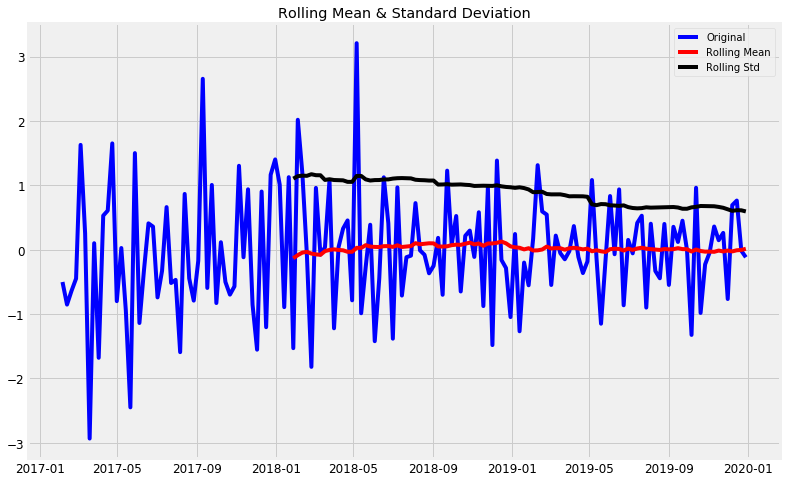

Results of Dickey-Fuller Test:
Test Statistic                  -4.565703
p-value                          0.000149
#Lags Used                       9.000000
Number of Observations Used    142.000000
Critical Value (1%)             -3.477262
Critical Value (5%)             -2.882118
Critical Value (10%)            -2.577743
dtype: float64


In [251]:
y_df['first_difference'] = y_df.rating - y_df.rating.shift(1)
test_stationarity(y_df.first_difference.dropna(inplace = False))

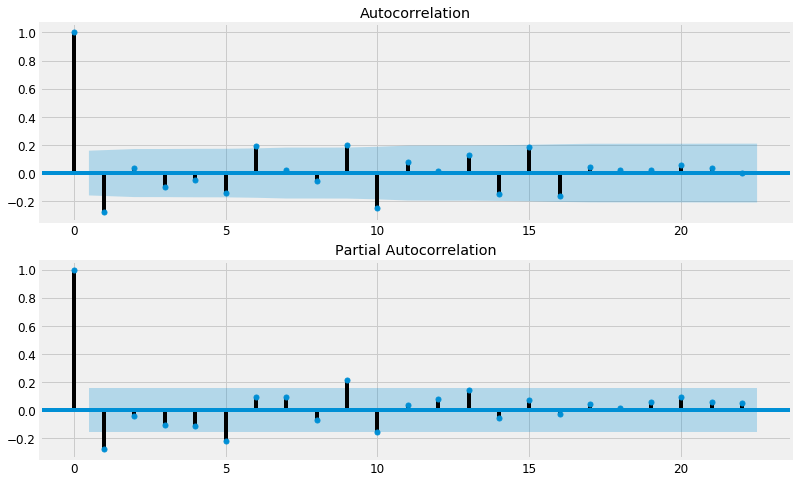

In [252]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_df.first_difference.iloc[1:], ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_df.first_difference.iloc[1:], ax=ax2)

In [253]:
mod = sm.tsa.statespace.SARIMAX(y_df.rating, trend='n', order=(0,1,0), seasonal_order=(1,0,0,52))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             rating   No. Observations:                  153
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 52)   Log Likelihood                -198.180
Date:                            Wed, 25 Dec 2019   AIC                            400.360
Time:                                    19:15:22   BIC                            406.408
Sample:                                01-29-2017   HQIC                           402.817
                                     - 12-29-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52       0.2008      0.113      1.783      0.075      -0.020       0.421
sigma2         0.7832      0.074   

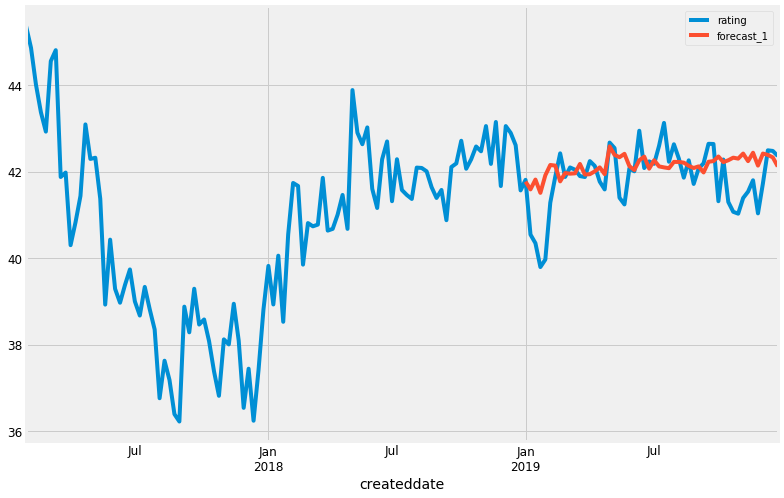

In [254]:
y_df['forecast_1'] = results.predict(start = len(y_df) - 52, end= len(y_df), dynamic= True)  
y_df[['rating', 'forecast_1']].plot(figsize=(12, 8))

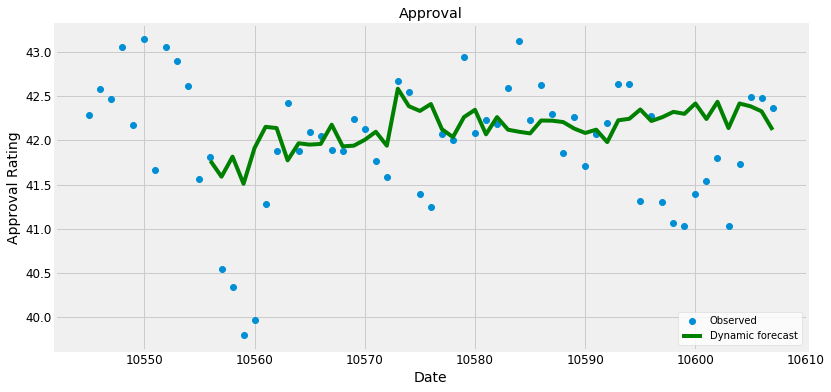

In [255]:
npredict = y_df.rating['2019'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='Approval', xlabel='Date', ylabel='Approval Rating')
ax.plot(df.index[-npredict-npre+1:], y_df.ix[-npredict-npre+1:, 'rating'], 'o', label='Observed')
ax.plot(df.index[-npredict-npre+1:], y_df.ix[-npredict-npre+1:, 'forecast_1'], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')

In [246]:
import datetime

In [247]:
from dateutil.relativedelta import relativedelta

In [266]:
start = datetime.datetime.strptime("2020-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(weeks=x) for x in range(0,52)]
future = pd.DataFrame(index=date_list, columns= y_df.columns)
y_df = pd.concat([y_df, future])

In [284]:
y_df

,rating,0,forecast_2
2017-01-29,45.363425,NaN,NaN
2017-02-05,44.862583,NaN,NaN
2017-02-12,44.010631,NaN,NaN
2017-02-19,43.373042,NaN,NaN
2017-02-26,42.925464,NaN,NaN
...,...,...,...
2021-12-19,NaN,42.557990,NaN
2021-12-26,NaN,42.553283,NaN
2022-01-02,NaN,42.555263,NaN
2022-01-09,NaN,42.545017,NaN


In [208]:
len(results.predict(start = 153, end = 205, dynamic= True))

53

In [287]:
forecast_2 = results.predict(start = 153, end = 205, dynamic= True) 

In [288]:
forecast_2

2020-01-05    42.410513
2020-01-12    42.156273
2020-01-19    42.116280
2020-01-26    42.005529
2020-02-02    42.040397
2020-02-09    42.304287
2020-02-16    42.423843
2020-02-23    42.533537
2020-03-01    42.423749
2020-03-08    42.467918
2020-03-15    42.457585
2020-03-22    42.427942
2020-03-29    42.423621
2020-04-05    42.497476
2020-04-12    42.474954
2020-04-19    42.402263
2020-04-26    42.365919
2020-05-03    42.583480
2020-05-10    42.557937
2020-05-17    42.327324
2020-05-24    42.296323
2020-05-31    42.463949
2020-06-07    42.450041
2020-06-14    42.638368
2020-06-21    42.465263
2020-06-28    42.496068
2020-07-05    42.484872
2020-07-12    42.568474
2020-07-19    42.674687
2020-07-26    42.494367
2020-08-02    42.575598
2020-08-09    42.509466
2020-08-16    42.420539
2020-08-23    42.501041
2020-08-30    42.391385
2020-09-06    42.462930
2020-09-13    42.487213
2020-09-20    42.577817
2020-09-27    42.576910
2020-10-04    42.311306
2020-10-11    42.504754
2020-10-18    42

In [289]:
y_df = pd.concat([y_df, forecast_2])

In [271]:
y_df['forecast_2'] = y_df[0]

In [290]:
y_df

,rating,0
2017-01-29,45.363425,NaN
2017-02-05,44.862583,NaN
2017-02-12,44.010631,NaN
2017-02-19,43.373042,NaN
2017-02-26,42.925464,NaN
...,...,...
2020-12-06,NaN,42.394057
2020-12-13,NaN,42.547533
2020-12-20,NaN,42.544647
2020-12-27,NaN,42.521199


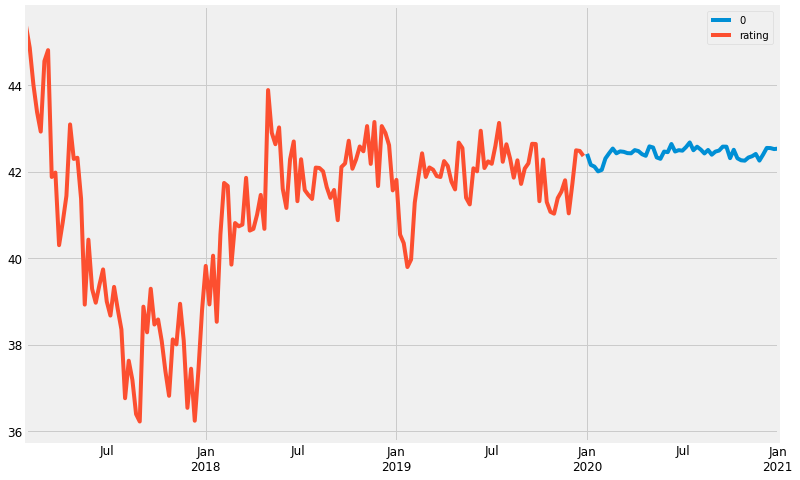

In [291]:
# y_df['forecast'] = results.predict(start = len(y_df), end = len(y_df) + 52, dynamic= True)  
y_df[[0, 'rating']].plot(figsize=(12, 8))

In [280]:
y_df

,rating,0
2017-01-29,45.363425,NaN
2017-02-05,44.862583,NaN
2017-02-12,44.010631,NaN
2017-02-19,43.373042,NaN
2017-02-26,42.925464,NaN
...,...,...
2021-12-19,NaN,42.557990
2021-12-26,NaN,42.553283
2022-01-02,NaN,42.555263
2022-01-09,NaN,42.545017


2017-01-29    0.0
2017-02-05    0.0
2017-02-12    0.0
2017-02-19    0.0
2017-02-26    0.0
             ... 
2020-12-06    0.0
2020-12-13    0.0
2020-12-20    0.0
2020-12-27    0.0
2021-01-03    0.0
Freq: W-SUN, Length: 206, dtype: float64

# Using ARIMA

In [40]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [41]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1563.1557794791909
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1288.654237194909
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:567.2364849614141
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:493.2421737283832
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:572.7573794186908


/Users/robblatt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:568.410928493015
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:500.9777031893812
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:484.99680066468204
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1352.4107617030018
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1101.1468705006962
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:509.55401615785524
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:444.9082779993868
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:519.2955733530945


/Users/robblatt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:515.5342387563139
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:460.62691153217287
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:434.6392352933254
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:400.70974574571744
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:358.59930267398494
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:461.0645643994439
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:361.3602621738645
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:361.0851008383647
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:357.24440233260964
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:387.0102535083573
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:361.42985981977455
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:386.35533709377296
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:343.02709952673047
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:438.0180042045774
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:347.54046640757906
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:346.7769381784127
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:342.3391946644149
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:376.18228264010963
A

/Users/robblatt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:353.80663453605314
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:363.04724844128737


/Users/robblatt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:361.3347843984739
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:375.80426632935195
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:355.1027429234403
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:390.716255918261


/Users/robblatt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:346.58845420746565
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:434.7634837563592
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:344.2945641454653
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:348.7657143896834
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:386.51422899812815
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:369.3448040075788
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:345.5493589338819
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:390.6198040542597
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:345.4162424191332
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:436.63958346680624
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:349.74991069549935
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:344.49673995408637
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:345.57939124701977
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:373.753110041536
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:351.6482953258863
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:386.2012602798402
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:342.91083823711494
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:432.83672823423103
ARI

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2019-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Approval')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

In [ ]:
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Approval Rating')
plt.legend()
plt.show()

In [ ]:
approve = df_merged.loc[df_merged['Category'] == 'approve']
disapprove = df_merged.loc[df_merged['Category'] == 'disapprove']
approve.shape, disapprove.shape

In [ ]:
approve.head()

In [ ]:
approve = approve.sort_values('createddate')
disapprove = disapprove.sort_values('createddate')
approve = approve.groupby('createddate')['rating'].mean().reset_index()
disapprove = disapprove.groupby('createddate')['rating'].mean().reset_index()
approve = approve.set_index('createddate')
disapprove = disapprove.set_index('createddate')
y_approve = approve['rating'].resample('MS').mean()
y_disapprove = disapprove['rating'].resample('MS').mean()
approve = pd.DataFrame({'createddate':y_approve.index, 'rating':y_approve.values})
disapprove = pd.DataFrame({'createddate': y_disapprove.index, 'rating': y_disapprove.values})
merged = approve.merge(disapprove, how='inner', on='createddate')
merged.rename(columns={'rating_x': 'approve_rating', 'rating_y': 'disapprove_rating'}, inplace=True)
merged.head()

In [ ]:
merged['disapprove_rating'] = merged['disapprove_rating'] * -1

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(merged['createddate'], merged['approve_rating'], 'b-', label = 'approve')
plt.plot(merged['createddate'], merged['disapprove_rating'], 'r-', label = 'disapprove')
plt.xlabel('Date'); plt.ylabel('rating'); 
plt.title('Approval and Disapproval')
plt.legend();

In [ ]:
try:
    first_date = merged.ix[np.min(list(np.where(merged['disapprove_rating'] < merged['approve_rating'])[0])), 'createddate']
    print("The first date where approval is higher than disaproval is {}.".format(first_date.date()))
except:
    print("The approval rating has never been higher than the disapproval ratings")

In [ ]:
disapprove

In [ ]:
disapprove['y'] = disapprove['y'] * -1

In [ ]:
from fbprophet import Prophet
approve = approve.rename(columns={'createddate': 'ds', 'rating': 'y'})
approve_model = Prophet(interval_width=0.95)
approve_model.fit(approve)
disapprove = disapprove.rename(columns={'createddate': 'ds', 'rating': 'y'})
disapprove_model = Prophet(interval_width=0.95)
disapprove_model.fit(disapprove)
approve_forecast = approve_model.make_future_dataframe(periods=12, freq='MS')
approve_forecast = approve_model.predict(approve_forecast)
disapprove_forecast = disapprove_model.make_future_dataframe(periods=12, freq='MS')
disapprove_forecast = disapprove_model.predict(disapprove_forecast)
plt.figure(figsize=(18, 6))
approve_model.plot(approve_forecast, xlabel = 'Date', ylabel = 'Approval Rating')
plt.title('Approval Ratings');

In [ ]:
plt.figure(figsize=(18, 6))
disapprove_model.plot(disapprove_forecast, xlabel = 'Date', ylabel = 'Disapproval Rating')
plt.title('Disapproval Ratings');

In [ ]:
approve_names = ['approve_%s' % column for column in approve_forecast.columns]
disapprove_names = ['disapprove_%s' % column for column in disapprove_forecast.columns]
merge_approve_forecast = approve_forecast.copy()
merge_disapprove_forecast = disapprove_forecast.copy()
merge_approve_forecast.columns = approve_names
merge_disapprove_forecast.columns = disapprove_names
forecast = pd.merge(merge_approve_forecast, merge_disapprove_forecast, how = 'inner', left_on = 'approve_ds', right_on = 'disapprove_ds')
forecast = forecast.rename(columns={'approve_ds': 'Date'}).drop('disapprove_ds', axis=1)
forecast.head()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['approve_trend'], 'b-')
plt.plot(forecast['Date'], forecast['disapprove_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Rating')
plt.title('Approval vs. Disapproval Trend');

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['approve_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['disapprove_yhat'], 'r-')
plt.legend();
plt.xlabel('Date');
plt.ylabel('Rating')
plt.title('Approval vs. Disapproval');

In [ ]:
approve_model.plot_components(approve_forecast);

In [ ]:
disapprove_model.plot_components(disapprove_forecast);